In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict
import operator

import os
import sys
from tqdm import tqdm

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

In [2]:
df = pd.read_csv('/kaggle/input/rapid-cxr-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*', '*'))}    
    
df['path'] = df['Image Index'].map(tmp)

### Feature 1: Dullness

In [3]:
def color_analysis(img):
    
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
        
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse=True)
    
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]):
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]):
            light_shade += x[1]
        
        shade_count += x[1]
        
        light_percent = round((float(light_shade)/shade_count)*100,2)
        
        dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    
    return light_percent, dark_percent

In [4]:
def perform_color_analysis(path, flag):
    img = Image.open(path).convert('RGB')
    
    size = img.size # Width, Height Channel 
    halves = (size[0]/2, size[1]/2)
    # left, upper, right, lower
    img1 = img.crop((0,0, size[0], halves[1]))
    img2 = img.crop((0,halves[1],size[0],size[1]))
    
    try:
        light_percent1, dark_percent1 = color_analysis(img1)
        light_percent2, dark_percent2 = color_analysis(img2)
    except Exception as e:
        return None
    
    light_percent = (light_percent1 + light_percent2) / 2
    dark_percent = (dark_percent1 + dark_percent2) / 2
    
    if flag == 'black':
        return dark_percent
    elif flag == 'white':
        return light_percent
    else: 
        return None

In [5]:
%%time
df['dullness'] = df['path'].apply(lambda x: perform_color_analysis(x, 'black'))

CPU times: user 25min 36s, sys: 6.06 s, total: 25min 42s
Wall time: 26min 38s


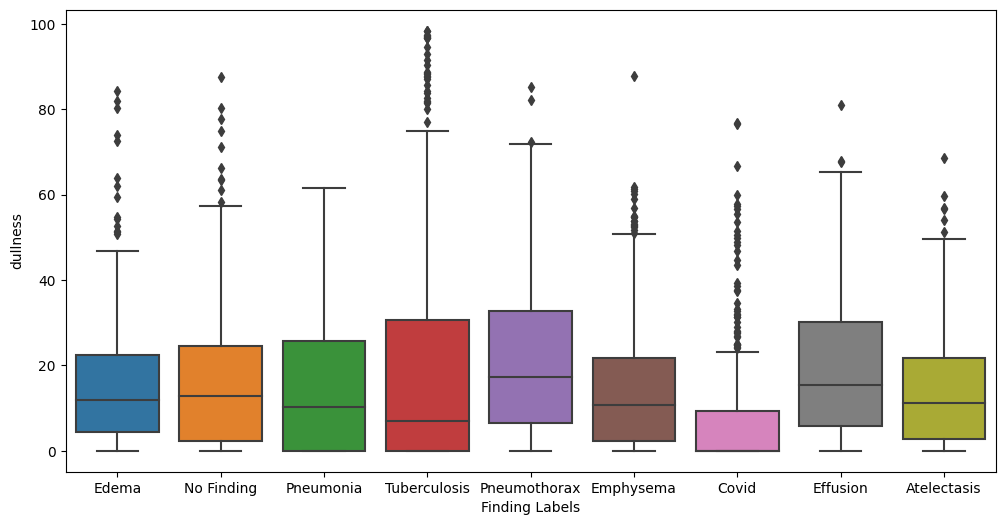

In [6]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Finding Labels'], y=df['dullness'])
plt.show()

### Feature 2: Whiteness

=> Image Whiteness Score

In [7]:
%%time
df['whiteness'] = df['path'].apply(lambda x: perform_color_analysis(x, 'white'))

CPU times: user 25min 37s, sys: 3.63 s, total: 25min 41s
Wall time: 25min 48s


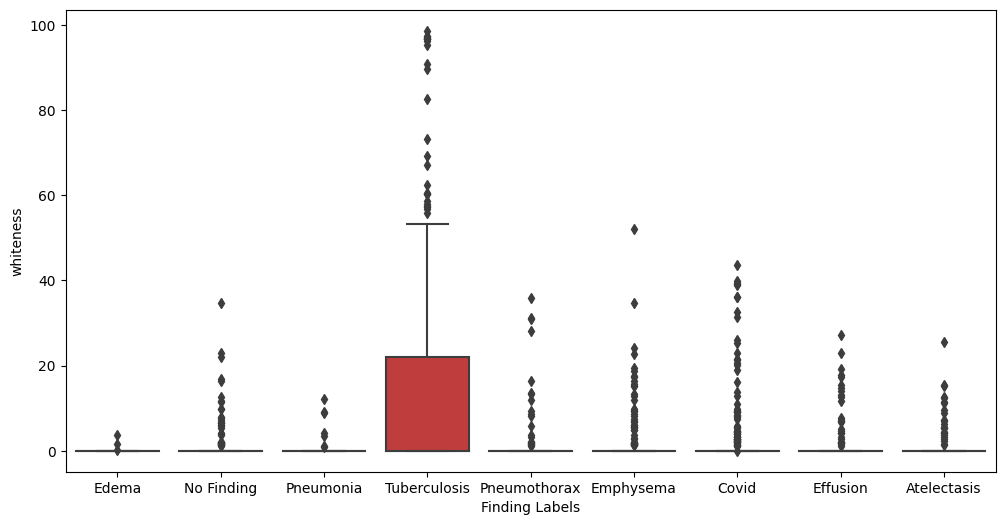

In [8]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Finding Labels'], y=df['whiteness'])
plt.show()

### Feature 3: Uniformity

=> Average Pixel Width

In [9]:
from skimage import feature

In [10]:
def average_pixel_width(path):
    im = Image.open(path).convert('L')
    im_array = np.asarray(im.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

In [11]:
%%time
df['apw'] = df['path'].apply(lambda x: average_pixel_width(x))

CPU times: user 13min 13s, sys: 37.3 s, total: 13min 50s
Wall time: 13min 57s


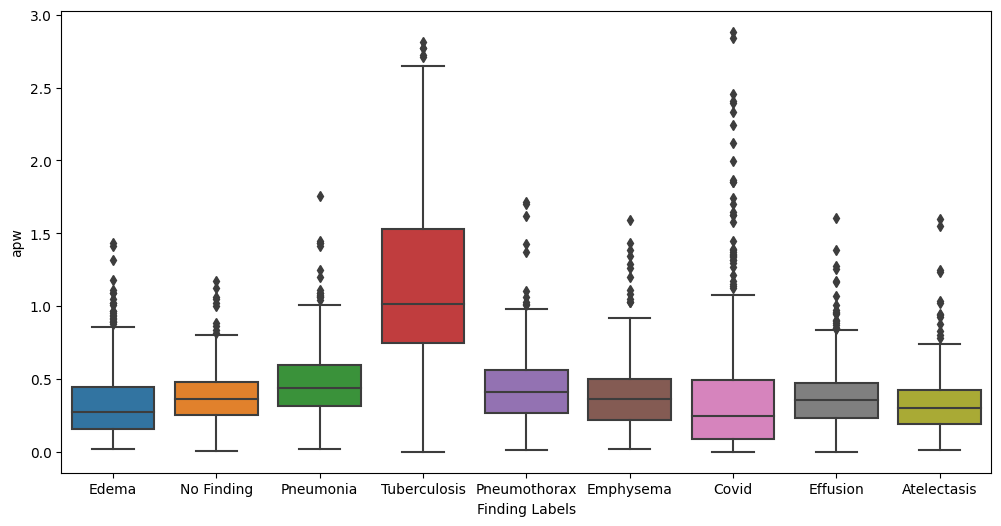

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Finding Labels'], y=df['apw'])
plt.show()

### Feature 4: Colors

=> Dominant Color of the Image
=> Average Color of the Image 

**Dominant Color**

In [13]:
def get_dominant_color(path):
    img = Image.open(path).convert('RGB')
    img = np.array(img)
    arr =  np.float32(img)
    pixels = arr.reshape((-1, 3))
    
    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)

    palette = np.uint8(centroids)
    quantized = palette[labels.flatten()]
    quantized = quantized.reshape(img.shape)

    # itemfreq 대신 np.bincount 사용
    dominant_color = palette[np.argmax(np.bincount(labels.flatten()))]
    
    return dominant_color

In [14]:
%%time
df['dominant_color'] = df['path'].apply(lambda x: get_dominant_color(x))

CPU times: user 21h 27min 59s, sys: 45min 16s, total: 22h 13min 15s
Wall time: 7h 6min 18s


In [15]:
df['dominant_red'] = df['dominant_color'].apply(lambda x: x[0]) / 255
df['dominant_green'] = df['dominant_color'].apply(lambda x: x[1]) / 255
df['dominant_blue'] = df['dominant_color'].apply(lambda x: x[2]) / 255

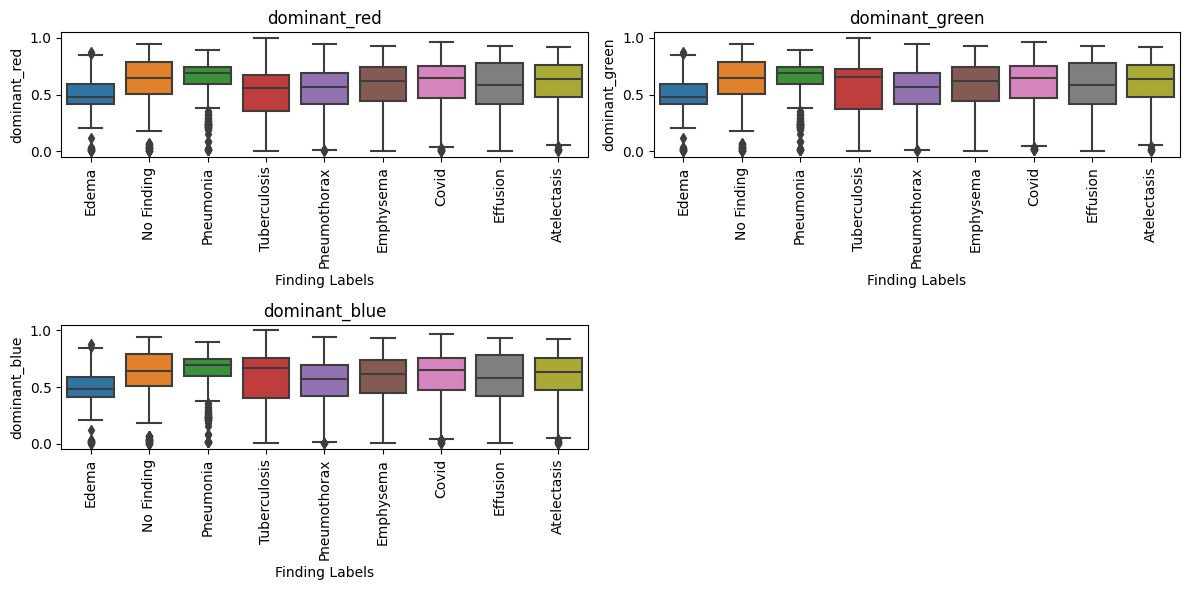

In [16]:
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.title('dominant_red')
sns.boxplot(x=df['Finding Labels'], y=df['dominant_red'])
plt.xticks(rotation=90)
plt.subplot(2,2,2)
plt.title('dominant_green')
sns.boxplot(x=df['Finding Labels'], y=df['dominant_green'])
plt.xticks(rotation=90)
plt.subplot(2,2,3)
plt.title('dominant_blue')
sns.boxplot(x=df['Finding Labels'], y=df['dominant_blue'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Average Color**

In [17]:
def get_average_color(path):
    img = Image.open(path).convert('RGB')
    img = np.array(img)
    average_red = img[:,:,0].mean()
    average_green = img[:,:,1].mean()
    average_blue = img[:,:,2].mean()
    
    average = [average_red,  average_green,  average_blue]
    return average

In [18]:
%%time
df['average_red'] = df['path'].apply(lambda x: get_average_color(x)[0])
df['average_green'] = df['path'].apply(lambda x: get_average_color(x)[1])
df['average_blue'] = df['path'].apply(lambda x: get_average_color(x)[2])


CPU times: user 4min 56s, sys: 7.91 s, total: 5min 4s
Wall time: 5min 18s


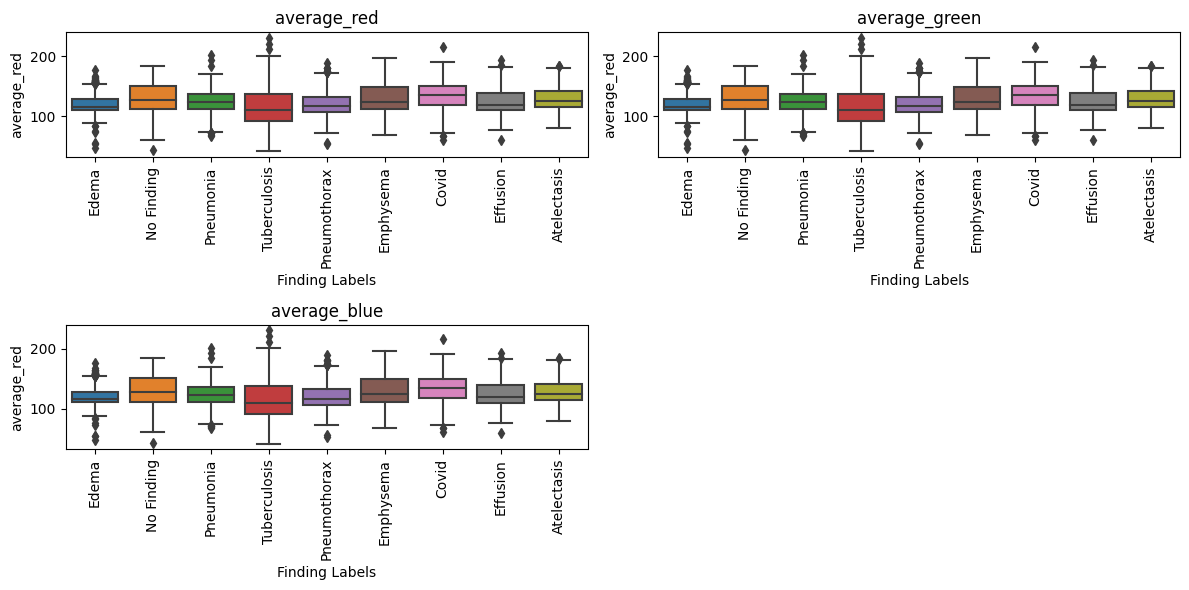

In [19]:
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.title('average_red')
sns.boxplot(x=df['Finding Labels'], y=df['average_red'])
plt.xticks(rotation=90)
plt.subplot(2,2,2)
plt.title('average_green')
sns.boxplot(x=df['Finding Labels'], y=df['average_red'])
plt.xticks(rotation=90)
plt.subplot(2,2,3)
plt.title('average_blue')
sns.boxplot(x=df['Finding Labels'], y=df['average_red'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Feature 5: Blurness

=> Width of th Image

In [20]:
def get_blurrness_score(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm

In [21]:
%%time
df['average_color'] = df['path'].apply(lambda x: get_blurrness_score(x))

CPU times: user 1min 57s, sys: 16 s, total: 2min 13s
Wall time: 1min 54s


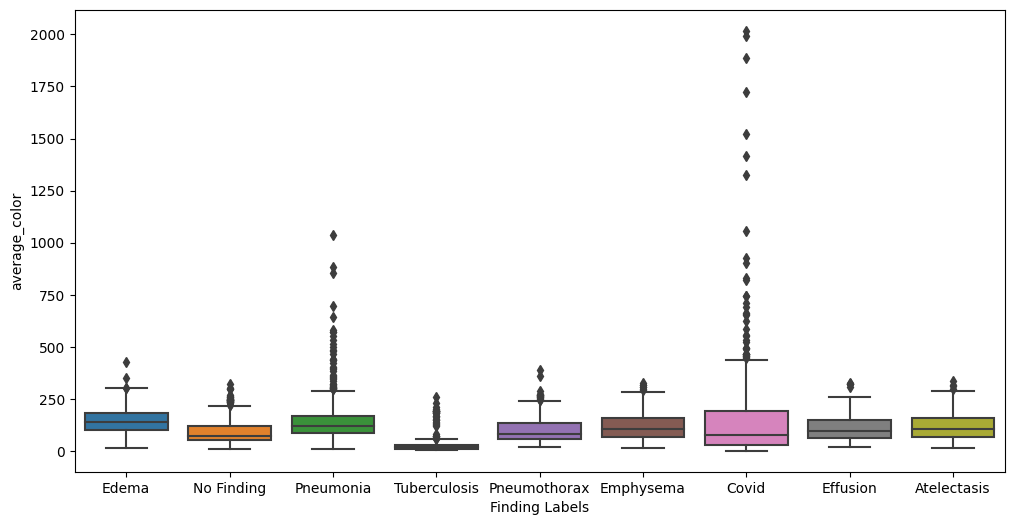

In [22]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Finding Labels'], y=df['average_color'])
plt.show()